# Skills Share Example :) 

This is an example of how to use the OpenAI API to leverage the capabilities of GPT for social science research :) 

You can find this project's Github [here](https://github.com/scm1210/GPT-classifier)

In order for this script to run, you will need to generate an API Key via OpenAI's website. You can do that [here](https://help.openai.com/en/articles/4936850-where-do-i-find-my-secret-api-key). Please do not share this with *anyone*, store it in an .env file, and add it to a .gitignore file to avoid any breaches in security.

I hope this is helpful.

## Side effects 

In [102]:
 import pandas as pd

In [103]:
# set directory to get .env file
%cd "/Users/stevenmesquiti/Desktop/SICSS project/Skills-share" 

/Users/stevenmesquiti/Desktop/SICSS project/Skills-share


In [104]:
# load in the dataframe, called subset .csv

url = "https://raw.githubusercontent.com/scm1210/GPT-classifier/main/Data/subset.csv"

df=pd.read_csv(url)
df.head() #grab the text column 

,Unnamed: 0,text,tweet_id,processed_text,generated_id
0,185802,Done with my second dose of vaccine\n#vaccinated,1432960690738720779,Done with my second dose of vaccine\n#vaccinated,J0WGTjpUXi
1,85127,I'm getting my first dose of @pfizer later tod...,1409759291775586305,I am getting my first dose of @pfizer later to...,ZTA2IiQYUN
2,2584,My mom and dad got their #shotofhope this week...,1367609550136877063,My mom and dad got their #shotofhope this week...,judxwRlJ6K
3,151362,Positives: Finally made it to MD to see my par...,1393040445073235976,Positives: Finally made it to MD to see my par...,SBHPG9tMo9
4,125073,That two weeks after yer second vaxx feeling 💪...,1412611910273359872,That two weeks after yer second vaxx feeling 💪...,tqiFY8lq7i


In [105]:
# side effects examples
side_effects = "https://raw.githubusercontent.com/scm1210/GPT-classifier/main/Examples/Vaccine_SideEffects_Examples.csv"

examples=pd.read_csv(side_effects)
examples.head(9)

,Text,Rating
0,So 24 hours after getting the second Pfizer sh...,1
1,My arm hurts from the booster😩 #PfizerGang #va...,1
2,I got my second vax 2 days ago &amp; I have al...,1
3,20 hours after (next morning):\n1. Only sore i...,1
4,2nd dose done! 💉💉#vaccinated https://t.co/H6j5...,0
5,Who else is playing the back-and-forth game th...,0
6,Vaccinated! So many feels on this long-awaited...,0
7,Was super nervous about getting my vaccine tod...,0


In [88]:
inputs = df.text.values #save the text
print(inputs)#print some inputs to view 

['Done with my second dose of vaccine\n#vaccinated'
 "I'm getting my first dose of @pfizer later today, pray for me. 🙏 #PfizerGang https://t.co/up46svWdJk"
 'My mom and dad got their #shotofhope this week!  We are all so grateful that we are one step closer to normalcy. @GovAndyBeshear , we are all proud to be a part of #teamkentucky. https://t.co/CR8SiCu3gH'
 'Positives: Finally made it to MD to see my parents and get hugs. #vaccinated \n\nNegatives: We may live here now. Drove by 10 gas stations tonight &amp; was one step behind the Gas Buddy app at each location. Anyone got ruby slippers I can borrow to get home?'
 'That two weeks after yer second vaxx feeling 💪💋\n\n#skpoli #covid19sk #vaxxed💉 https://t.co/AwocqstdE1'
 '@jesscbeard miss Pfizer would never do that to you #PfizerGang'
 'Why are there so many people against the vaccine 💉 ?#Moderna #vaccination #CovidVaccine #Pfizer #vaccinated'
 'For two reasons:\n\nOne, I’ve been fortunately able to mostly #StayHome, but a year later,

In [106]:
#load other dependencies 
import argparse
import json
import os

import numpy as np
import openai
import pandas as pd
import random
import time
from tqdm.notebook import tqdm
from dotenv import load_dotenv


In [107]:
title='Vaccine-disclosure-100'
subtitle='test'
stim_set=title+'-'+subtitle
seed=1
temperature=0.1 #want a low baking temp to have little variability or creativity 
engine='gpt-3.5-turbo' #change this to use different models
n_context=1
cache = True   
resume=False
# MIDI='freq' #or 'name', 'number', 'freq'
audience='People'
item='Tweets'

load_dotenv()

apiKey = os.environ.get('steven_key') #for stevens key 

openai.api_key = apiKey

if cache:
    random.seed(seed)

In [108]:
print(examples.columns)

Index(['Text', 'Rating'], dtype='object')


In [109]:
def generate_prompt(current):#(example_idxs, current_pair):
    prompt = f"""Your task is to identify if a piece of text contains vaccine side-effect information. 
You will be provided with four examples of text that contain vaccine side-effect information 
and four pieces of text that do not contain vaccine side-effect information. 
Answer only with a number: 1 if vaccine side-effect information is present, 
and 0 if vaccine side-effect information is absent.
  

Text: {examples.Text.iloc[0]}
Rating: {examples.Rating.iloc[0]}
    
Text: {examples.Text.iloc[1]}
Rating: {examples.Rating.iloc[1]}

Text: {examples.Text.iloc[2]}
Rating: {examples.Rating.iloc[2]}

Text: {examples.Text.iloc[3]}
Rating: {examples.Rating.iloc[3]}

Text: {examples.Text.iloc[4]}
Rating: {examples.Rating.iloc[4]}
    
Text: {examples.Text.iloc[5]}
Rating: {examples.Rating.iloc[5]}

Text: {examples.Text.iloc[6]}
Rating: {examples.Rating.iloc[6]}

Text: {examples.Text.iloc[7]}
Rating: {examples.Rating.iloc[7]}

    
Text: {inputs[current]}
Rating:
"""
    if n_context==0:
        prompt = f"""Does the following piece of text contain vaccine side-effect information? A
        nswer only with a number: 1 if vaccine side-effect information is present, 
        and 0 if vaccine side-effect information is absent. Here is the text:\n{inputs[current]}"""
    
    return prompt

cache_folder = f'cache/{stim_set}'
os.makedirs(cache_folder, exist_ok=True)
def create_cache_filename():
    filename = f'{stim_set}-{n_context}-{engine}-{temperature}-{seed}'
    # if args.shuffle_context_each_draw:
    #     filename += '-shuffle'
    return os.path.join(cache_folder, filename + '.json')

if not resume:
    visited = []
    predicted_ratings = np.zeros((len(inputs)))
    request_count = 0

cache = {}

if cache and os.path.exists(create_cache_filename()):
    cache = json.load(open(create_cache_filename()))
cached_keys = list(cache.keys())

for idx1, bname1 in enumerate(tqdm(inputs)):
    current = idx1
    if current in visited and predicted_ratings[current]!=0:
        print(f'Already visited {current}')
        continue

    visited.append(current)

    key = f'{current}'
    if key in cached_keys:
        choices = cache[key]['choices']
        print('Using cached choices for key', key)
    else:
        prompt = generate_prompt(current)#(example_idxs, current_pair)
        response=False
        i=0
        while not response:
            i+=1
            try:
                response = openai.ChatCompletion.create(
                    model=engine,
                    messages=[{'role':'user', 'content':prompt}],
                    temperature=temperature,
                    timeout=10
                )
            except Exception as e:
                print(f'Attempt {i} failed')
                time.sleep(5)
        choices = [dict(choice.items()) for choice in response.choices]

        cache[key] = {
            'prompt': prompt,
            'choices': choices,
            'created': response.created
        }

        request_count += 1
        if cache and request_count % 5 == 0:
            json.dump(cache, open(create_cache_filename(), 'w'))

    try:
        answer = choices[0]['message']['content'].replace('\n', '').strip()
        predicted_ratings[idx1] = int(answer)
    except:
        print('Error', cache[key])

os.makedirs(f'predictions/{stim_set}', exist_ok=True)
np.save(f'predictions/{stim_set}/{stim_set}-{n_context}-{engine}-{temperature}-{seed}.npy', predicted_ratings)


  0%|          | 0/100 [00:00<?, ?it/s]

Attempt 1 failed


In [110]:
# load in the dataframe, called subset .csv
url = "https://raw.githubusercontent.com/scm1210/GPT-classifier/main/Data/subset.csv"
df=pd.read_csv(url)
df.head() #grab the text column 
predicted_ratings=np.load(f'predictions/{stim_set}/{stim_set}-{n_context}-{engine}-{temperature}-{seed}.npy', allow_pickle=True) #heres where we read in the predictions
df.head()

,Unnamed: 0,text,tweet_id,processed_text,generated_id
0,185802,Done with my second dose of vaccine\n#vaccinated,1432960690738720779,Done with my second dose of vaccine\n#vaccinated,J0WGTjpUXi
1,85127,I'm getting my first dose of @pfizer later tod...,1409759291775586305,I am getting my first dose of @pfizer later to...,ZTA2IiQYUN
2,2584,My mom and dad got their #shotofhope this week...,1367609550136877063,My mom and dad got their #shotofhope this week...,judxwRlJ6K
3,151362,Positives: Finally made it to MD to see my par...,1393040445073235976,Positives: Finally made it to MD to see my par...,SBHPG9tMo9
4,125073,That two weeks after yer second vaxx feeling 💪...,1412611910273359872,That two weeks after yer second vaxx feeling 💪...,tqiFY8lq7i


In [111]:
predicted_ratings # just to check it ran smoothly
df.columns

Index(['Unnamed: 0', 'text', 'tweet_id', 'processed_text', 'generated_id'], dtype='object')

In [112]:
df_gpt35=pd.DataFrame(predicted_ratings, columns=['Vaccine-disclosure-GPT']) #rename to the respective column name you need 
df_gpt35['text']=df.text.values
df_gpt35['generated_id']=df.generated_id.values #this is your index variable, so something like an ID


In [113]:
#save the work to your own directory
output_directory = '/Users/stevenmesquiti/Desktop/SICSS project/SICSS-classifier'
os.makedirs(output_directory, exist_ok=True)
df_gpt35.to_csv(os.path.join(output_directory, f'{stim_set}-{n_context}-{engine}-{temperature}-{seed}.csv'), index=False)

## Get Performance Scores 

In [114]:
#load dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [115]:
# set directory to get .env file
%cd "/Users/stevenmesquiti/Desktop/SICSS project/Skills-share" 

/Users/stevenmesquiti/Desktop/SICSS project/Skills-share


In [116]:
# load the data
VSE = "https://raw.githubusercontent.com/scm1210/GPT-classifier/main/Data-Viz/Compare_VSE_GPT.csv"

side_effects=pd.read_csv(VSE)
side_effects.head() #grab the text column 

,Vaccine-disclosure-GPT,text_x,generated_id,Vaccine side-effects
0,1.0,"So, I was super confused as to why I got a not...",zXkdHys3og,0.0
1,0.0,"""Two-jabs"" McCormick at your service. #5gready...",chOTkq5nBv,0.0
2,0.0,Nanomachines should be active now right? I can...,wawaJFZ51H,0.0
3,1.0,@AmyFeld Thanks for the encouragement and soli...,qWZWbC4OsX,1.0
4,0.0,#vaccinated \n\nThank you #COVISHIELD \n\nThan...,dk2DyN8mEj,0.0


In [117]:
# Construct labels and stuff 
# Assuming you have the true labels (human-coded) and predicted labels (machine-coded)

true_labels = side_effects["Vaccine side-effects"] #change to appropriate column name
predicted_labels = side_effects["Vaccine-disclosure-GPT"] #change to appropriate column name

# Convert the labels to numeric format if they are stored as strings
true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

#Precision focuses on the accuracy of positive predictions, indicating how often the classifier 
#is correct when it predicts positive.
#Recall focuses on the completeness of positive predictions, indicating how well the classifier 
#can identify positive instances.
#F1 Combines precision and recall into a single value to provide a balanced evaluation of a classifier's performance

Precision: 0.35714285714285715
Recall: 1.0
F1 Score: 0.5263157894736842


In [118]:
cm = confusion_matrix(true_labels, predicted_labels)

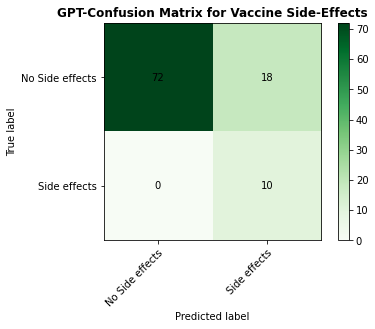

In [119]:
class_names = ['No Side effects', 'Side effects']  # Replace with your desired class labels

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the confusion matrix as an image
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)


ax.set(xticks=np.arange(len(class_names)),
       yticks=np.arange(len(class_names)),
       xticklabels=class_names,
       yticklabels=class_names,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate and align the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor",fontsize=10)

# Loop over the data and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

# Add a bold title
ax.set_title("GPT-Confusion Matrix for Vaccine Side-Effects", fontweight='bold')
# Add footer with precision, recall, and F1 scores


# Save the plot as a high-resolution image
plt.savefig('/Users/stevenmesquiti/Desktop/SICSS project/Skills-share/GPT-classifier/Data-Vizside_effects_plot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Political 

In [66]:
import pandas as pd

In [67]:
# set directory to get .env file
%cd "/Users/stevenmesquiti/Desktop/SICSS project/SICSS-classifier" 

/Users/stevenmesquiti/Desktop/SICSS project/SICSS-classifier


In [68]:
url = "https://raw.githubusercontent.com/scm1210/GPT-classifier/main/Data/subset.csv"

df=pd.read_csv(url)
df.head() #grab the text column 

,Unnamed: 0,text,tweet_id,processed_text,generated_id
0,185802,Done with my second dose of vaccine\n#vaccinated,1432960690738720779,Done with my second dose of vaccine\n#vaccinated,J0WGTjpUXi
1,85127,I'm getting my first dose of @pfizer later tod...,1409759291775586305,I am getting my first dose of @pfizer later to...,ZTA2IiQYUN
2,2584,My mom and dad got their #shotofhope this week...,1367609550136877063,My mom and dad got their #shotofhope this week...,judxwRlJ6K
3,151362,Positives: Finally made it to MD to see my par...,1393040445073235976,Positives: Finally made it to MD to see my par...,SBHPG9tMo9
4,125073,That two weeks after yer second vaxx feeling 💪...,1412611910273359872,That two weeks after yer second vaxx feeling 💪...,tqiFY8lq7i


In [69]:
#examples 
politics = 'https://raw.githubusercontent.com/scm1210/GPT-classifier/main/Examples/Example_Politics.csv'
examples=pd.read_csv(politics)
examples.head(9)

,Text,Rating
0,Second Pfizer shot for the COVID-19 vaccine is...,1
1,Hubs and I are getting our 2nd #FauciOuchie to...,1
2,Have they said #Aspirin was only invented for ...,1
3,#PandemicOfTheUnvaccinated sounds like a #Repu...,1
4,Second Pfizer shot for the COVID-19 vaccine is...,0
5,Got my vaccination as soon as I could get an a...,0
6,Tomorrow is 2 weeks since the second shot! Ful...,0
7,Got my vaccination as soon as I could get an a...,0


In [70]:
inputs = df.text.values #save the text
print(inputs)#print some inputs to view 

['Done with my second dose of vaccine\n#vaccinated'
 "I'm getting my first dose of @pfizer later today, pray for me. 🙏 #PfizerGang https://t.co/up46svWdJk"
 'My mom and dad got their #shotofhope this week!  We are all so grateful that we are one step closer to normalcy. @GovAndyBeshear , we are all proud to be a part of #teamkentucky. https://t.co/CR8SiCu3gH'
 'Positives: Finally made it to MD to see my parents and get hugs. #vaccinated \n\nNegatives: We may live here now. Drove by 10 gas stations tonight &amp; was one step behind the Gas Buddy app at each location. Anyone got ruby slippers I can borrow to get home?'
 'That two weeks after yer second vaxx feeling 💪💋\n\n#skpoli #covid19sk #vaxxed💉 https://t.co/AwocqstdE1'
 '@jesscbeard miss Pfizer would never do that to you #PfizerGang'
 'Why are there so many people against the vaccine 💉 ?#Moderna #vaccination #CovidVaccine #Pfizer #vaccinated'
 'For two reasons:\n\nOne, I’ve been fortunately able to mostly #StayHome, but a year later,

In [71]:
#load other dependencies 
import argparse
import json
import os

import numpy as np
import openai
import pandas as pd
import random
import time
from tqdm.notebook import tqdm
from dotenv import load_dotenv
import os

In [72]:
title='Vaccine-Politics-100'
subtitle='test'
stim_set=title+'-'+subtitle
seed=1
temperature=0.1 #want a low baking temp to have little variability or creativity 
engine='gpt-3.5-turbo' #change this to use different models
n_context=1
cache = True   
resume=False
# MIDI='freq' #or 'name', 'number', 'freq'
audience='People'
item='Tweets'

load_dotenv()

apiKey = os.environ.get('steven_key') #for stevens key 

openai.api_key = apiKey

if cache:
    random.seed(seed)

In [73]:
#### Political content

def generate_prompt(current):
    prompt = f"""Your task is to assess whether the following text mentioning vaccines contains political content. Provide your rating by responding with a number: 1 if the text contains political content, and 0 if it does not.

Text: {examples.Text.iloc[0]}
Rating: {examples.Rating.iloc[0]}
    
Text: {examples.Text.iloc[1]}
Rating: {examples.Rating.iloc[1]}

Text: {examples.Text.iloc[2]}
Rating: {examples.Rating.iloc[2]}

Text: {examples.Text.iloc[3]}
Rating: {examples.Rating.iloc[3]}

Text: {examples.Text.iloc[4]}
Rating: {examples.Rating.iloc[4]}
    
Text: {examples.Text.iloc[5]}
Rating: {examples.Rating.iloc[5]}

Text: {examples.Text.iloc[6]}
Rating: {examples.Rating.iloc[6]}

Text: {examples.Text.iloc[7]}
Rating: {examples.Rating.iloc[7]}

Please assess the political content of the following text mentioning vaccines and provide your rating:
Text: {inputs[current]}
Rating:
"""
    if n_context == 0:
        prompt = f"""Does the following text mentioning vaccines contain political content? Respond with a number: 1 if the text contains political content, and 0 if the text does not contain political content. Here is the text:\n{inputs[current]}"""
    
    return prompt


cache_folder = f'cache/{stim_set}'
os.makedirs(cache_folder, exist_ok=True)
def create_cache_filename():
    filename = f'{stim_set}-{n_context}-{engine}-{temperature}-{seed}'
    # if args.shuffle_context_each_draw:
    #     filename += '-shuffle'
    return os.path.join(cache_folder, filename + '.json')

if not resume:
    visited = []
    predicted_ratings = np.zeros((len(inputs)))
    request_count = 0

cache = {}

if cache and os.path.exists(create_cache_filename()):
    cache = json.load(open(create_cache_filename()))
cached_keys = list(cache.keys())

for idx1, bname1 in enumerate(tqdm(inputs)):
    current = idx1
    if current in visited and predicted_ratings[current]!=0:
        print(f'Already visited {current}')
        continue

    visited.append(current)

    key = f'{current}'
    if key in cached_keys:
        choices = cache[key]['choices']
        print('Using cached choices for key', key)
    else:
        prompt = generate_prompt(current)#(example_idxs, current_pair)
        response=False
        i=0
        while not response:
            i+=1
            try:
                response = openai.ChatCompletion.create(
                    model=engine,
                    messages=[{'role':'user', 'content':prompt}],
                    temperature=temperature,
                    timeout=10
                )
            except Exception as e:
                print(f'Attempt {i} failed')
                time.sleep(5)
        choices = [dict(choice.items()) for choice in response.choices]

        cache[key] = {
            'prompt': prompt,
            'choices': choices,
            'created': response.created
        }

        request_count += 1
        if cache and request_count % 5 == 0:
            json.dump(cache, open(create_cache_filename(), 'w'))

    try:
        answer = choices[0]['message']['content'].replace('\n', '').strip()
        predicted_ratings[idx1] = int(answer)
    except:
        print('Error', cache[key])

os.makedirs(f'predictions/{stim_set}', exist_ok=True)
np.save(f'predictions/{stim_set}/{stim_set}-{n_context}-{engine}-{temperature}-{seed}.npy', predicted_ratings)


  0%|          | 0/100 [00:00<?, ?it/s]

Attempt 1 failed
Attempt 1 failed
Attempt 1 failed
Attempt 1 failed


In [74]:
url = "https://raw.githubusercontent.com/scm1210/GPT-classifier/main/Data/subset.csv"

df=pd.read_csv(url)
df.head() #grab the text column # df_gpt4 = np.zeros((predicted_ratings.size, 3))
# df_gpt4[np.arange(predicted_ratings.size), predicted_ratings.astype(int)] = 1
predicted_ratings=np.load(f'predictions/{stim_set}/{stim_set}-{n_context}-{engine}-{temperature}-{seed}.npy', allow_pickle=True) #heres where we read in the predictions
df.head()

,Unnamed: 0,text,tweet_id,processed_text,generated_id
0,185802,Done with my second dose of vaccine\n#vaccinated,1432960690738720779,Done with my second dose of vaccine\n#vaccinated,J0WGTjpUXi
1,85127,I'm getting my first dose of @pfizer later tod...,1409759291775586305,I am getting my first dose of @pfizer later to...,ZTA2IiQYUN
2,2584,My mom and dad got their #shotofhope this week...,1367609550136877063,My mom and dad got their #shotofhope this week...,judxwRlJ6K
3,151362,Positives: Finally made it to MD to see my par...,1393040445073235976,Positives: Finally made it to MD to see my par...,SBHPG9tMo9
4,125073,That two weeks after yer second vaxx feeling 💪...,1412611910273359872,That two weeks after yer second vaxx feeling 💪...,tqiFY8lq7i


In [75]:
predicted_ratings # just to check it ran smoothly
df.columns

Index(['Unnamed: 0', 'text', 'tweet_id', 'processed_text', 'generated_id'], dtype='object')

In [76]:
df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

In [77]:
df.head()

,ID,text,tweet_id,processed_text,generated_id
0,185802,Done with my second dose of vaccine\n#vaccinated,1432960690738720779,Done with my second dose of vaccine\n#vaccinated,J0WGTjpUXi
1,85127,I'm getting my first dose of @pfizer later tod...,1409759291775586305,I am getting my first dose of @pfizer later to...,ZTA2IiQYUN
2,2584,My mom and dad got their #shotofhope this week...,1367609550136877063,My mom and dad got their #shotofhope this week...,judxwRlJ6K
3,151362,Positives: Finally made it to MD to see my par...,1393040445073235976,Positives: Finally made it to MD to see my par...,SBHPG9tMo9
4,125073,That two weeks after yer second vaxx feeling 💪...,1412611910273359872,That two weeks after yer second vaxx feeling 💪...,tqiFY8lq7i


In [78]:
df_gpt35=pd.DataFrame(predicted_ratings, columns=['Vaccine-disclosure-GPT']) #rename to the respective column name you need 
df_gpt35['text']=df.text.values
df_gpt35['generated_id']=df.generated_id.values #this is your index variable, so something like an ID

In [79]:
#save the work
output_directory = '/Users/stevenmesquiti/Desktop/SICSS project/SICSS-classifier'
os.makedirs(output_directory, exist_ok=True)
df_gpt35.to_csv(os.path.join(output_directory, f'{stim_set}-{n_context}-{engine}-{temperature}-{seed}.csv'), index=False)

## Look at the Precision 

In [80]:
pol = "https://raw.githubusercontent.com/scm1210/GPT-classifier/main/Data-Viz/Compare_POL_GPT.csv"

politics=pd.read_csv(pol)
politics.head() #grab the text column 

,Vaccine-Political-GPT,text_x,generated_id,Political content
0,0.0,"So, I was super confused as to why I got a not...",zXkdHys3og,0.0
1,0.0,"""Two-jabs"" McCormick at your service. #5gready...",chOTkq5nBv,0.0
2,0.0,Nanomachines should be active now right? I can...,wawaJFZ51H,0.0
3,0.0,@AmyFeld Thanks for the encouragement and soli...,qWZWbC4OsX,0.0
4,1.0,#vaccinated \n\nThank you #COVISHIELD \n\nThan...,dk2DyN8mEj,0.0


In [81]:
# Construct labels and stuff 
# Assuming you have the true labels (human-coded) and predicted labels (machine-coded)

true_labels = politics["Political content"] #change to appropriate column name
predicted_labels = politics["Vaccine-Political-GPT"] #change to appropriate column name

# Convert the labels to numeric format if they are stored as strings
true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

#Precision focuses on the accuracy of positive predictions, indicating how often the classifier 
#is correct when it predicts positive.
#Recall focuses on the completeness of positive predictions, indicating how well the classifier 
#can identify positive instances.
#F1 Combines precision and recall into a single value to provide a balanced evaluation of a classifier's performance

Precision: 0.25
Recall: 0.3333333333333333
F1 Score: 0.28571428571428575


In [82]:
cm = confusion_matrix(true_labels, predicted_labels)

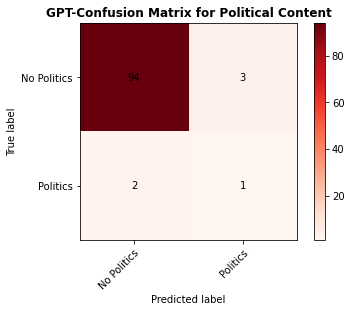

In [83]:
class_names = ['No Politics', 'Politics']  # Replace with your desired class labels


# Create a figure and axes
fig, ax = plt.subplots()

# Plot the confusion matrix as an image
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(len(class_names)),
       yticks=np.arange(len(class_names)),
       xticklabels=class_names,
       yticklabels=class_names,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate and align the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over the data and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

# Add a bold title
ax.set_title("GPT-Confusion Matrix for Political Content", fontweight='bold')


# Save the plot as a high-resolution image
plt.savefig('/Users/stevenmesquiti/Desktop/SICSS project/Skills-share/GPT-classifier/Data-Vizpolitics_plot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()